# Liquidity Microstructure Analysis

**Track**: Extensions | **Difficulty**: ⭐⭐⭐⭐ Advanced | **Time**: 90-120 minutes

**Prerequisites**:
- Completed Core Track (all 3 notebooks)
- Completed Extensions: Market Maker Simulation
- Understanding of market microstructure
- Familiarity with regression analysis

**Learning Objectives**:
1. Measure liquidity using academic metrics (Kyle's lambda, Amihud ratio)
2. Analyze order book depth and price impact
3. Identify liquidity gaps that amplify crashes
4. Understand how liquidity evaporates during stress
5. Compare normal vs flash crash market microstructure

**Key Concepts**:
- Kyle's lambda (price impact coefficient)
- Amihud illiquidity measure
- Order book depth and resilience
- Liquidity air pockets
- Effective vs quoted spreads

---

## Setup

In [1]:
# ============================================================================
# SETUP - Liquidity Microstructure Analysis
# ============================================================================

import sys
import os
from pathlib import Path

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running in local Jupyter environment")

# Setup for Colab
if IN_COLAB:
    print("\n📥 Setting up Colab environment...")
    
    if not os.path.exists('/content/etf-flash-crash-2015'):
        print("  Cloning repository...")
        !git clone https://github.com/shiong-tan/etf-flash-crash-2015.git /content/etf-flash-crash-2015
        print("  ✅ Repository cloned")
    else:
        print("  ✅ Repository exists")
    
    print("  Installing dependencies...")
    !pip install -q pandas numpy matplotlib seaborn scipy
    print("  ✅ Dependencies installed")
    
    os.chdir('/content/etf-flash-crash-2015')
    sys.path.insert(0, '/content/etf-flash-crash-2015/src')
    
else:
    print("\n📂 Setting up local environment...")
    notebook_dir = Path().resolve()
    
    # Determine src directory location based on notebook location
    # Case 1: In notebooks/core/ or notebooks/extensions/ → go up 2 levels
    if notebook_dir.parent.name == 'notebooks':
        project_root = notebook_dir.parent.parent
        src_dir = project_root / 'src'
    # Case 2: In notebooks/ directory → go up 1 level
    elif notebook_dir.name == 'notebooks':
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    # Case 3: In project root (has notebooks/ subdirectory) → use directly
    elif (notebook_dir / 'notebooks').exists():
        project_root = notebook_dir
        src_dir = project_root / 'src'
    # Case 4: Fallback - assume we're one level deep
    else:
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    
    sys.path.insert(0, str(src_dir))
    print(f"  ✅ Added src to path: {src_dir}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dataclasses import dataclass

from order_book_dynamics import (
    OrderBookSnapshot,
    FlashCrashOrderBook,
    calculate_kyle_lambda,
    calculate_amihud_illiquidity,
    identify_liquidity_gaps
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
np.random.seed(42)

if IN_COLAB:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
else:
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

print("\n" + "="*60)
print("✅ SETUP COMPLETE - Ready for liquidity analysis!")
print("="*60)

💻 Running in local Jupyter environment

📂 Setting up local environment...
  ✅ Added src to path: /Users/shiongtan/projects/etf-flash-crash-2015/src



✅ SETUP COMPLETE - Ready for liquidity analysis!


---

## Part 1: Bid-Ask Spreads

### Exercise 1.1: Quoted vs Effective Spreads

Understanding different spread measures and their implications.

=== BID-ASK SPREAD ANALYSIS ===
Scenario        Best Bid     Best Ask     Spread ($)   Spread (bps)
Normal          $199.98      $200.02      $0.0400      2.00       
Stressed        $199.80      $200.20      $0.4000      20.00      
Flash Crash     $198.00      $202.00      $4.0000      200.00     


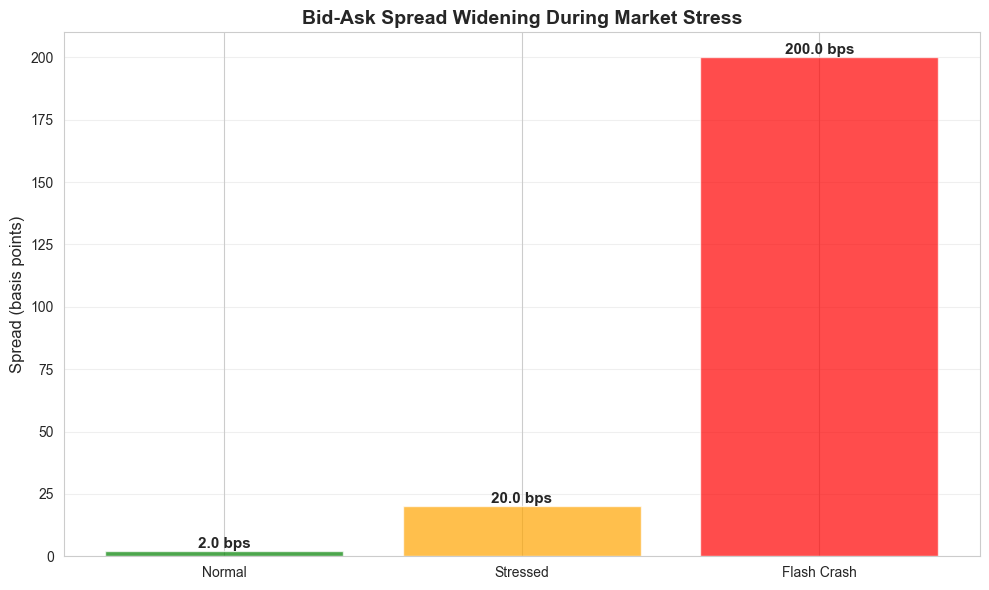


💡 Spread increased 100x from normal to flash crash


In [2]:
# Create sample order book snapshots
def create_snapshot(bid_price, ask_price, depth=10000, timestamp=None):
    """Helper to create order book snapshot."""
    if timestamp is None:
        timestamp = pd.Timestamp.now()
    
    return OrderBookSnapshot(
        timestamp=timestamp,
        bids={bid_price: depth, bid_price - 0.01: depth, bid_price - 0.02: depth},
        asks={ask_price: depth, ask_price + 0.01: depth, ask_price + 0.02: depth},
        last_trade=None,
        fair_value=(bid_price + ask_price) / 2,
        halt_status=False
    )

# Normal market: 2 basis point spread
normal_snapshot = create_snapshot(bid_price=199.98, ask_price=200.02)

# Stressed market: 20 basis point spread
stressed_snapshot = create_snapshot(bid_price=199.80, ask_price=200.20)

# Flash crash: 100+ basis point spread
crash_snapshot = create_snapshot(bid_price=198.00, ask_price=202.00)

scenarios = [
    ('Normal', normal_snapshot),
    ('Stressed', stressed_snapshot),
    ('Flash Crash', crash_snapshot)
]

print("=== BID-ASK SPREAD ANALYSIS ===")
print(f"{'Scenario':<15} {'Best Bid':<12} {'Best Ask':<12} {'Spread ($)':<12} {'Spread (bps)':<12}")
print("=" * 70)

results = []
for name, snapshot in scenarios:
    best_bid = max(snapshot.bids.keys())
    best_ask = min(snapshot.asks.keys())
    spread_dollars = best_ask - best_bid
    spread_bps = snapshot.spread_bps()
    
    results.append({
        'Scenario': name,
        'Best_Bid': best_bid,
        'Best_Ask': best_ask,
        'Spread_Dollars': spread_dollars,
        'Spread_BPS': spread_bps
    })
    
    print(f"{name:<15} ${best_bid:<11.2f} ${best_ask:<11.2f} ${spread_dollars:<11.4f} {spread_bps:<11.2f}")

# Visualize spread widening
df_spreads = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df_spreads))
bars = ax.bar(x, df_spreads['Spread_BPS'], color=['green', 'orange', 'red'], alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(df_spreads['Scenario'])
ax.set_ylabel('Spread (basis points)', fontsize=12)
ax.set_title('Bid-Ask Spread Widening During Market Stress', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, df_spreads['Spread_BPS']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f} bps',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

spread_multiple = results[-1]['Spread_BPS'] / results[0]['Spread_BPS']
print(f"\n💡 Spread increased {spread_multiple:.0f}x from normal to flash crash")

### Exercise 1.2: Price Impact Analysis

Calculate execution price for market orders of different sizes.

=== PRICE IMPACT ANALYSIS ===
Order Size: Market BUY orders (lifting offers)


Normal Market:
     100 shares: $200.0200 (impact: +0.00 bps)
   1,000 shares: $200.0200 (impact: +0.00 bps)
   5,000 shares: $200.0200 (impact: +0.00 bps)
  10,000 shares: $200.0200 (impact: +0.00 bps)
  20,000 shares: $200.0250 (impact: +0.25 bps)

Stressed Market:
     100 shares: $200.2000 (impact: +0.00 bps)
   1,000 shares: $200.2000 (impact: +0.00 bps)
   5,000 shares: $200.2000 (impact: +0.00 bps)
  10,000 shares: $200.2000 (impact: +0.00 bps)
  20,000 shares: $200.2050 (impact: +0.25 bps)

Flash Crash Market:
     100 shares: $202.0000 (impact: +0.00 bps)
   1,000 shares: $202.0000 (impact: +0.00 bps)
   5,000 shares: $202.0000 (impact: +0.00 bps)
  10,000 shares: $202.0000 (impact: +0.00 bps)
  20,000 shares: $202.0050 (impact: +0.25 bps)


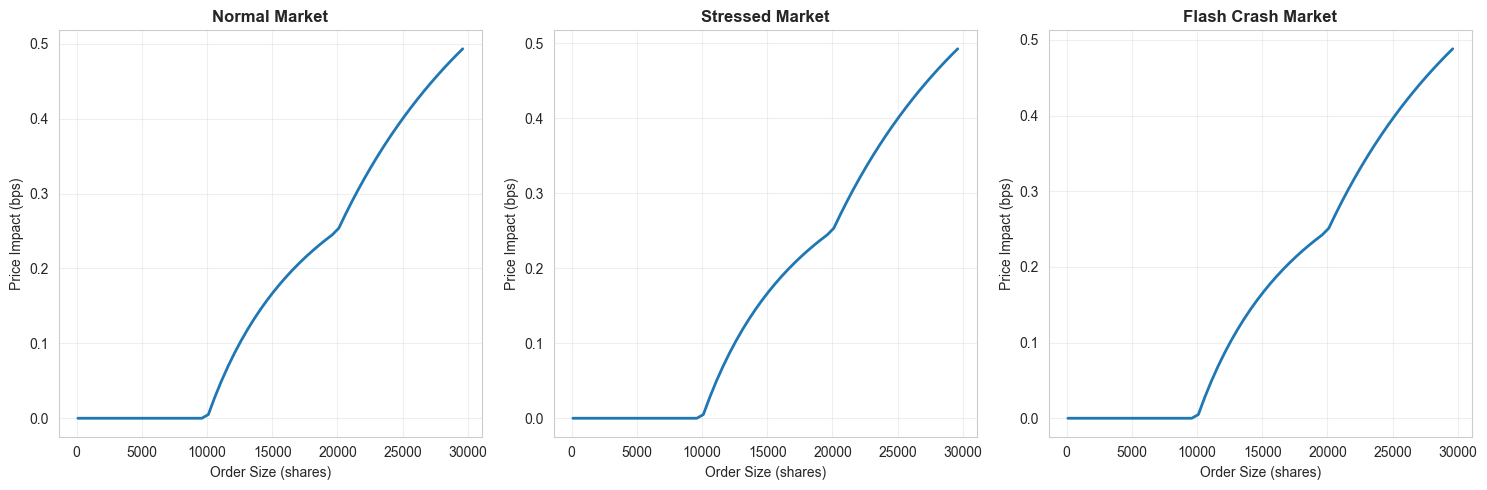


💡 Price impact increases non-linearly with order size
   Larger orders walk up the order book, paying progressively worse prices


In [3]:
# Analyze price impact for different order sizes
order_sizes = [100, 1000, 5000, 10000, 20000]

print("=== PRICE IMPACT ANALYSIS ===")
print(f"Order Size: Market BUY orders (lifting offers)\n")

for name, snapshot in scenarios:
    print(f"\n{name} Market:")
    best_ask = min(snapshot.asks.keys())
    
    for size in order_sizes:
        avg_price = snapshot.price_impact(size, 'buy')
        
        if not np.isnan(avg_price):
            impact_bps = ((avg_price - best_ask) / best_ask) * 10000
            print(f"  {size:>6,} shares: ${avg_price:.4f} (impact: {impact_bps:+.2f} bps)")
        else:
            print(f"  {size:>6,} shares: INSUFFICIENT LIQUIDITY")

# Visualize price impact curve
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, snapshot) in enumerate(scenarios):
    ax = axes[idx]
    best_ask = min(snapshot.asks.keys())
    
    sizes = []
    impacts = []
    
    for size in range(100, 30001, 500):
        avg_price = snapshot.price_impact(size, 'buy')
        if not np.isnan(avg_price):
            sizes.append(size)
            impact_bps = ((avg_price - best_ask) / best_ask) * 10000
            impacts.append(impact_bps)
    
    ax.plot(sizes, impacts, linewidth=2)
    ax.set_xlabel('Order Size (shares)')
    ax.set_ylabel('Price Impact (bps)')
    ax.set_title(f'{name} Market', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Price impact increases non-linearly with order size")
print("   Larger orders walk up the order book, paying progressively worse prices")

---

## Part 2: Kyle's Lambda (Price Impact Coefficient)

### Exercise 2.1: Calculate Kyle's Lambda

Kyle's lambda measures how much price moves per unit of signed order flow.

=== KYLE'S LAMBDA (PRICE IMPACT COEFFICIENT) ===

Normal Market:      λ = -0.00000021
Stressed Market:    λ = -0.00000034
Flash Crash:        λ = 0.00000233

λ increased -10.9x from normal to flash crash

Interpretation:
  Normal: Each 1000 shares moves price $0.0002
  Crash:  Each 1000 shares moves price $0.0023


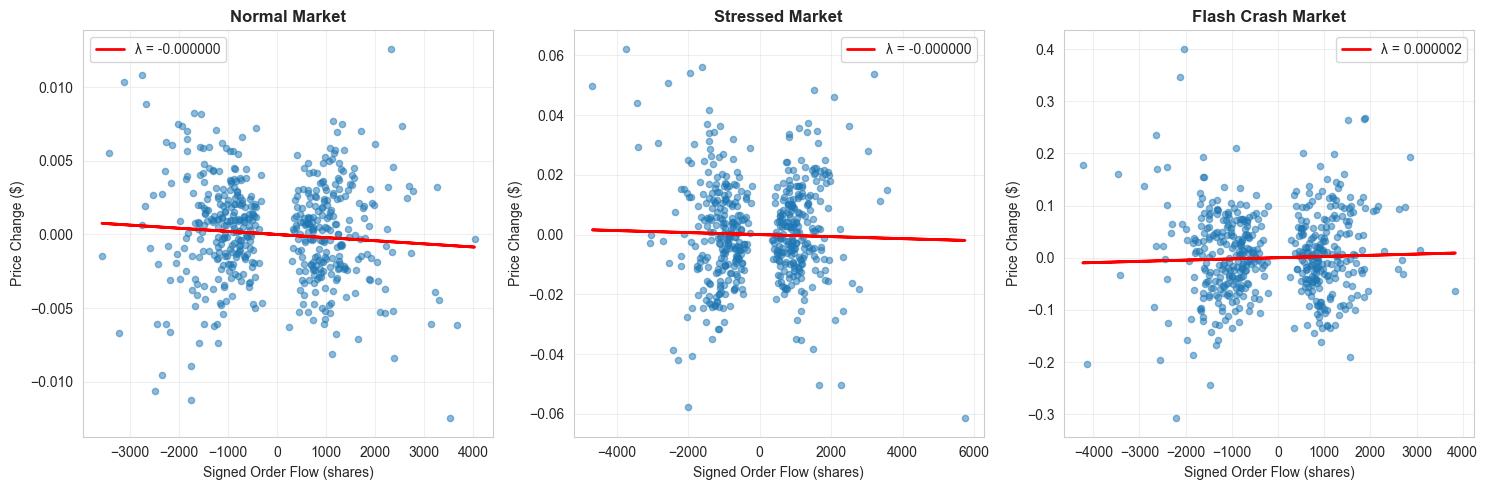


💡 Higher λ = lower liquidity = greater price impact per trade


In [4]:
# Simulate trading activity in different market regimes

def simulate_trades(n_trades, volatility, base_price=200.0, avg_size=1000):
    """Simulate realistic trade data."""
    trades = []
    price = base_price
    
    for i in range(n_trades):
        # Random order flow
        side = np.random.choice(['buy', 'sell'])
        size = int(np.random.lognormal(np.log(avg_size), 0.5))
        
        # Price impact: proportional to order size and volatility
        impact = (size / 10000) * volatility * np.random.normal(0, 1)
        if side == 'buy':
            price += impact
        else:
            price -= impact
        
        # Add random noise
        price += np.random.normal(0, volatility * 0.1)
        
        trades.append({
            'timestamp': pd.Timestamp('2015-08-24 09:30:00') + pd.Timedelta(seconds=i*10),
            'price': max(price, 0.01),  # Prevent negative prices
            'size': size,
            'side': side
        })
    
    return pd.DataFrame(trades)

# Generate trade data for different regimes
normal_trades = simulate_trades(n_trades=500, volatility=0.02, base_price=200.0)
stressed_trades = simulate_trades(n_trades=500, volatility=0.10, base_price=200.0)
crash_trades = simulate_trades(n_trades=500, volatility=0.50, base_price=200.0)

# Calculate Kyle's lambda for each regime
# Note: orderbook_snapshots parameter is reserved for future use
empty_snapshots = []

lambda_normal = calculate_kyle_lambda(normal_trades, empty_snapshots)
lambda_stressed = calculate_kyle_lambda(stressed_trades, empty_snapshots)
lambda_crash = calculate_kyle_lambda(crash_trades, empty_snapshots)

print("=== KYLE'S LAMBDA (PRICE IMPACT COEFFICIENT) ===")
print(f"\nNormal Market:      λ = {lambda_normal:.8f}")
print(f"Stressed Market:    λ = {lambda_stressed:.8f}")
print(f"Flash Crash:        λ = {lambda_crash:.8f}")

lambda_increase = lambda_crash / lambda_normal
print(f"\nλ increased {lambda_increase:.1f}x from normal to flash crash")
print(f"\nInterpretation:")
print(f"  Normal: Each 1000 shares moves price ${abs(lambda_normal * 1000):.4f}")
print(f"  Crash:  Each 1000 shares moves price ${abs(lambda_crash * 1000):.4f}")

# Visualize price impact relationship
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, trades, lambda_val) in enumerate([
    ('Normal', normal_trades, lambda_normal),
    ('Stressed', stressed_trades, lambda_stressed),
    ('Flash Crash', crash_trades, lambda_crash)
]):
    ax = axes[idx]
    
    # Calculate signed volume and price changes
    df = trades.copy()
    df['signed_volume'] = np.where(df['side'] == 'buy', df['size'], -df['size'])
    df['price_change'] = df['price'].diff()
    
    # Scatter plot
    ax.scatter(df['signed_volume'], df['price_change'], alpha=0.5, s=20)
    
    # Add regression line
    x = df['signed_volume'].values
    y_pred = lambda_val * x
    ax.plot(x, y_pred, 'r-', linewidth=2, label=f'λ = {lambda_val:.6f}')
    
    ax.set_xlabel('Signed Order Flow (shares)')
    ax.set_ylabel('Price Change ($)')
    ax.set_title(f'{name} Market', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Higher λ = lower liquidity = greater price impact per trade")

---

## Part 3: Amihud Illiquidity Measure

### Exercise 3.1: Calculate Amihud Ratio

Amihud measure captures price movement per dollar traded.

=== AMIHUD ILLIQUIDITY MEASURE ===

Normal Market:      Amihud = 0.0000000000
Stressed Market:    Amihud = 0.0000000001
Flash Crash:        Amihud = 0.0000000005

Amihud increased 23.7x from normal to flash crash

Interpretation:
  Lower values = more liquid (price moves less per dollar traded)
  Higher values = less liquid (price moves more per dollar traded)


/var/folders/2h/qpjxmlz92fng3n589pg14f5c0000gn/T/ipykernel_89019/3082475973.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_bars = trades_df['price'].resample('1T').ohlc()
/var/folders/2h/qpjxmlz92fng3n589pg14f5c0000gn/T/ipykernel_89019/3082475973.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_volume = trades_df['size'].resample('1T').sum()


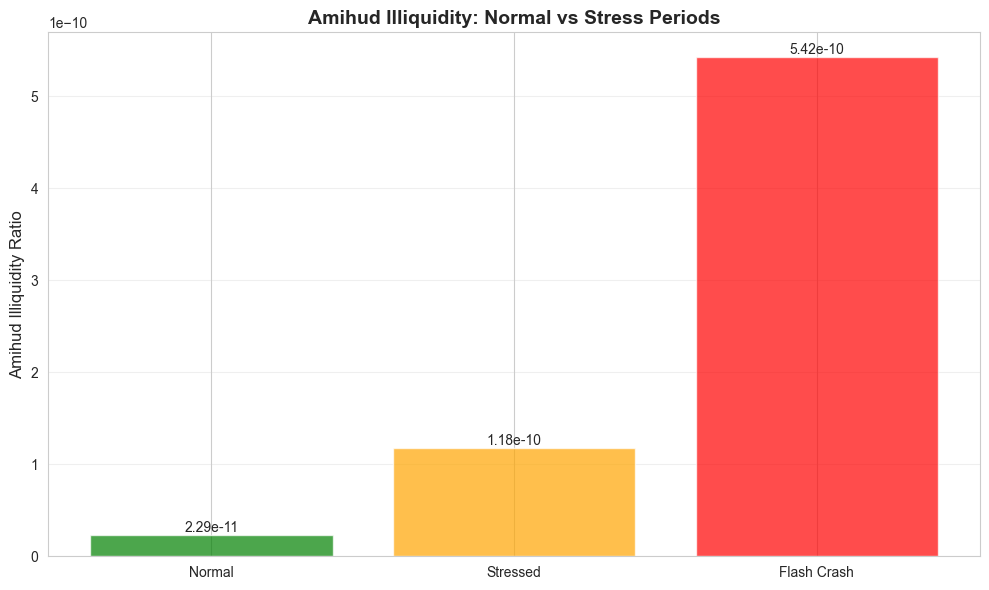


💡 Both Kyle's lambda and Amihud measure show liquidity evaporates during crisis


In [5]:
# Calculate Amihud illiquidity for simulated data

def calculate_amihud_from_trades(trades_df):
    """Helper to calculate Amihud from trade data."""
    # Resample to minute-level bars
    trades_df = trades_df.set_index('timestamp')
    
    # Calculate OHLC prices and volume
    minute_bars = trades_df['price'].resample('1T').ohlc()
    minute_volume = trades_df['size'].resample('1T').sum()
    
    # Use close prices for Amihud calculation
    prices = minute_bars['close'].dropna()
    volumes = minute_volume[prices.index]
    
    return calculate_amihud_illiquidity(prices, volumes)

amihud_normal = calculate_amihud_from_trades(normal_trades)
amihud_stressed = calculate_amihud_from_trades(stressed_trades)
amihud_crash = calculate_amihud_from_trades(crash_trades)

print("=== AMIHUD ILLIQUIDITY MEASURE ===")
print(f"\nNormal Market:      Amihud = {amihud_normal:.10f}")
print(f"Stressed Market:    Amihud = {amihud_stressed:.10f}")
print(f"Flash Crash:        Amihud = {amihud_crash:.10f}")

amihud_increase = amihud_crash / amihud_normal
print(f"\nAmihud increased {amihud_increase:.1f}x from normal to flash crash")

print(f"\nInterpretation:")
print(f"  Lower values = more liquid (price moves less per dollar traded)")
print(f"  Higher values = less liquid (price moves more per dollar traded)")

# Visualize Amihud measure comparison
fig, ax = plt.subplots(figsize=(10, 6))

scenarios_amihud = ['Normal', 'Stressed', 'Flash Crash']
amihud_values = [amihud_normal, amihud_stressed, amihud_crash]
colors = ['green', 'orange', 'red']

bars = ax.bar(scenarios_amihud, amihud_values, color=colors, alpha=0.7)
ax.set_ylabel('Amihud Illiquidity Ratio', fontsize=12)
ax.set_title('Amihud Illiquidity: Normal vs Stress Periods', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, amihud_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2e}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 Both Kyle's lambda and Amihud measure show liquidity evaporates during crisis")

---

## Part 4: Order Book Depth and Liquidity Gaps

### Exercise 4.1: Analyze Order Book Depth

=== ORDER BOOK DEPTH ANALYSIS ===

Depth within X% of midpoint (bid depth, ask depth):

Normal Market:
  Within  0.1%: 30,000 / 30,000 shares (total:  60,000)
  Within  0.5%: 30,000 / 30,000 shares (total:  60,000)
  Within  1.0%: 30,000 / 30,000 shares (total:  60,000)
  Within  2.0%: 30,000 / 30,000 shares (total:  60,000)
  Within  5.0%: 30,000 / 30,000 shares (total:  60,000)

Stressed Market:
  Within  0.1%:  9,600 /  9,600 shares (total:  19,200)
  Within  0.5%:  9,600 /  9,600 shares (total:  19,200)
  Within  1.0%:  9,600 /  9,600 shares (total:  19,200)
  Within  2.0%:  9,600 /  9,600 shares (total:  19,200)
  Within  5.0%:  9,600 /  9,600 shares (total:  19,200)

Flash Crash Market:
  Within  0.1%:      0 /      0 shares (total:       0)
  Within  0.5%:  1,000 /  1,000 shares (total:   2,000)
  Within  1.0%:  1,660 /  1,660 shares (total:   3,320)
  Within  2.0%:  1,660 /  1,660 shares (total:   3,320)
  Within  5.0%:  1,660 /  1,660 shares (total:   3,320)



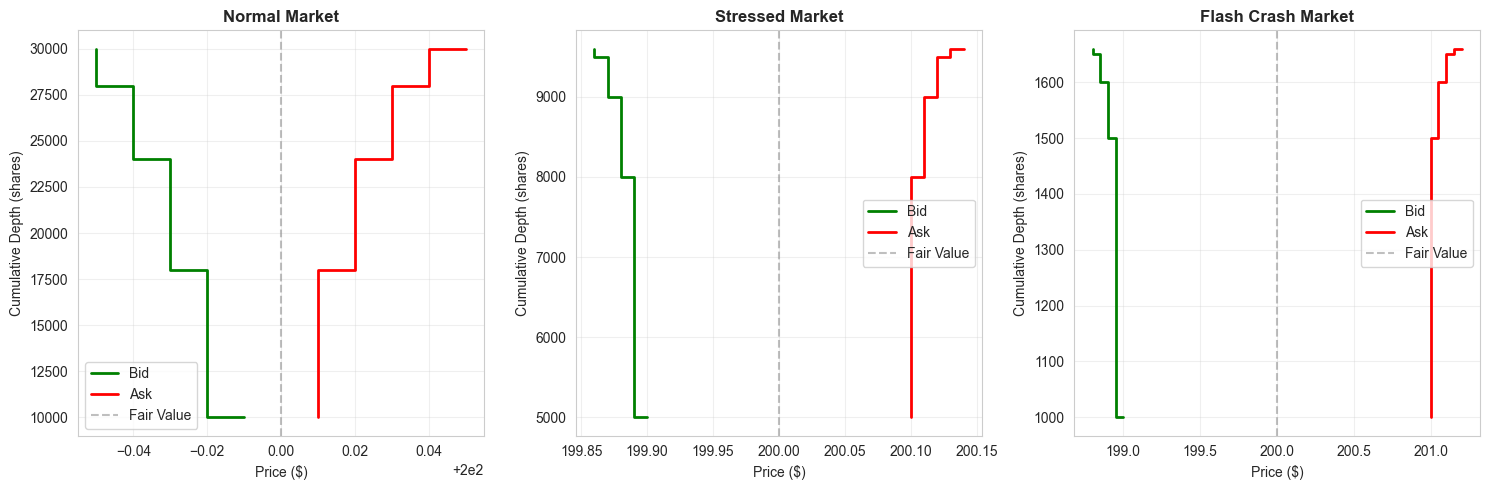

💡 During flash crash, order book depth collapses
   Even small orders can cause significant price impact


In [6]:
# Create detailed order books with varying depth

def create_detailed_orderbook(regime='normal', base_price=200.0):
    """Create order book with realistic depth profile."""
    
    if regime == 'normal':
        # Tight market, deep book
        tick_size = 0.01
        depth_profile = [10000, 8000, 6000, 4000, 2000]  # Decreasing depth
        spread = 0.02
    elif regime == 'stressed':
        # Wider market, thinner book
        tick_size = 0.01
        depth_profile = [5000, 3000, 1000, 500, 100]
        spread = 0.20
    else:  # crash
        # Wide market with gaps
        tick_size = 0.05
        depth_profile = [1000, 500, 100, 50, 10]
        spread = 2.00
    
    best_bid = base_price - spread / 2
    best_ask = base_price + spread / 2
    
    # Build order book
    bids = {}
    asks = {}
    
    for i, depth in enumerate(depth_profile):
        bids[best_bid - i * tick_size] = depth
        asks[best_ask + i * tick_size] = depth
    
    return OrderBookSnapshot(
        timestamp=pd.Timestamp.now(),
        bids=bids,
        asks=asks,
        last_trade=None,
        fair_value=base_price,
        halt_status=False
    )

# Create order books
normal_book = create_detailed_orderbook('normal')
stressed_book = create_detailed_orderbook('stressed')
crash_book = create_detailed_orderbook('crash')

# Analyze depth at different distances
distances = [0.001, 0.005, 0.01, 0.02, 0.05]  # 0.1%, 0.5%, 1%, 2%, 5%

print("=== ORDER BOOK DEPTH ANALYSIS ===")
print(f"\nDepth within X% of midpoint (bid depth, ask depth):\n")

for name, book in [('Normal', normal_book), ('Stressed', stressed_book), ('Flash Crash', crash_book)]:
    print(f"{name} Market:")
    for dist in distances:
        bid_depth, ask_depth = book.depth_at_distance(dist)
        total_depth = bid_depth + ask_depth
        print(f"  Within {dist*100:>4.1f}%: {bid_depth:>6,} / {ask_depth:>6,} shares (total: {total_depth:>7,})")
    print()

# Visualize order book profiles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, book) in enumerate([('Normal', normal_book), ('Stressed', stressed_book), ('Flash Crash', crash_book)]):
    ax = axes[idx]
    
    # Extract bid and ask data
    bid_prices = sorted(book.bids.keys(), reverse=True)
    bid_sizes = [book.bids[p] for p in bid_prices]
    
    ask_prices = sorted(book.asks.keys())
    ask_sizes = [book.asks[p] for p in ask_prices]
    
    # Plot as step function
    ax.step(bid_prices, np.cumsum(bid_sizes), where='post', label='Bid', color='green', linewidth=2)
    ax.step(ask_prices, np.cumsum(ask_sizes), where='pre', label='Ask', color='red', linewidth=2)
    
    ax.axvline(book.fair_value, color='gray', linestyle='--', alpha=0.5, label='Fair Value')
    ax.set_xlabel('Price ($)')
    ax.set_ylabel('Cumulative Depth (shares)')
    ax.set_title(f'{name} Market', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 During flash crash, order book depth collapses")
print("   Even small orders can cause significant price impact")

### Exercise 4.2: Identify Liquidity Gaps (Air Pockets)

=== LIQUIDITY GAPS (AIR POCKETS) ===

Identified 2 liquidity gap(s) > 1.0%:

Gap 1: $195.00 to $197.50
        Size: $2.50 (1.28%)

Gap 2: $190.00 to $194.00
        Size: $4.00 (2.11%)

⚠️  Liquidity gaps cause:
   1. Extreme slippage for market orders
   2. Price discontinuities (jumps)
   3. Triggering of stop-loss cascades
   4. Market maker withdrawal (can't price risk)


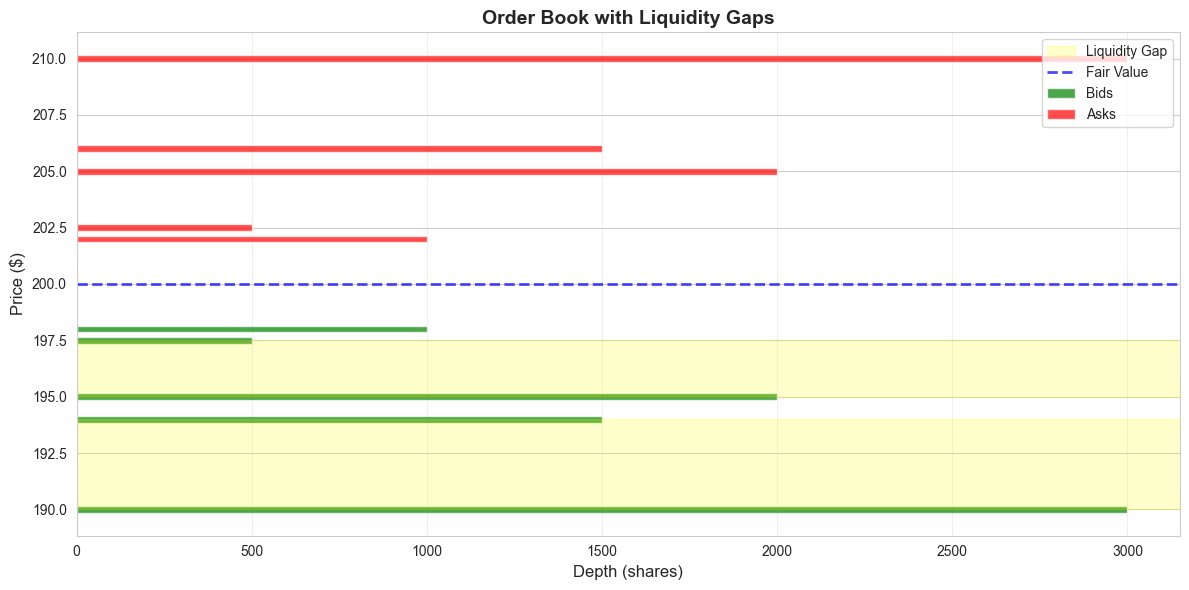


💡 August 24, 2015: Multiple ETFs had order books that looked like this
   Market orders fell through gaps, triggering additional stop-losses


In [7]:
# Create order book with gaps (realistic flash crash scenario)

def create_gapped_orderbook(base_price=200.0):
    """Create order book with liquidity gaps."""
    
    bids = {
        198.00: 1000,
        197.50: 500,
        # GAP from 197.50 to 195.00 (1.25% gap)
        195.00: 2000,
        194.00: 1500,
        # GAP from 194.00 to 190.00 (2.06% gap)
        190.00: 3000,
    }
    
    asks = {
        202.00: 1000,
        202.50: 500,
        # GAP from 202.50 to 205.00 (1.23% gap)
        205.00: 2000,
        206.00: 1500,
        # GAP from 206.00 to 210.00 (1.94% gap)
        210.00: 3000,
    }
    
    return OrderBookSnapshot(
        timestamp=pd.Timestamp.now(),
        bids=bids,
        asks=asks,
        last_trade=None,
        fair_value=base_price,
        halt_status=False
    )

gapped_book = create_gapped_orderbook()

# Identify gaps
gaps = identify_liquidity_gaps(gapped_book, threshold_pct=1.0)

print("=== LIQUIDITY GAPS (AIR POCKETS) ===")
print(f"\nIdentified {len(gaps)} liquidity gap(s) > 1.0%:\n")

for i, (lower, upper) in enumerate(gaps, 1):
    gap_size = upper - lower
    gap_pct = (gap_size / lower) * 100
    print(f"Gap {i}: ${lower:.2f} to ${upper:.2f}")
    print(f"        Size: ${gap_size:.2f} ({gap_pct:.2f}%)")
    print()

print("⚠️  Liquidity gaps cause:")
print("   1. Extreme slippage for market orders")
print("   2. Price discontinuities (jumps)")
print("   3. Triggering of stop-loss cascades")
print("   4. Market maker withdrawal (can't price risk)")

# Visualize gapped order book
fig, ax = plt.subplots(figsize=(12, 6))

bid_prices = sorted(gapped_book.bids.keys(), reverse=True)
bid_sizes = [gapped_book.bids[p] for p in bid_prices]

ask_prices = sorted(gapped_book.asks.keys())
ask_sizes = [gapped_book.asks[p] for p in ask_prices]

# Plot bids and asks
ax.barh(bid_prices, bid_sizes, height=0.3, color='green', alpha=0.7, label='Bids')
ax.barh(ask_prices, ask_sizes, height=0.3, color='red', alpha=0.7, label='Asks')

# Highlight gaps
for lower, upper in gaps:
    ax.axhspan(lower, upper, alpha=0.2, color='yellow', label='Liquidity Gap' if lower == gaps[0][0] else '')

ax.axhline(gapped_book.fair_value, color='blue', linestyle='--', linewidth=2, label='Fair Value', alpha=0.7)
ax.set_xlabel('Depth (shares)', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Order Book with Liquidity Gaps', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 August 24, 2015: Multiple ETFs had order books that looked like this")
print("   Market orders fell through gaps, triggering additional stop-losses")

---

## Part 5: Flash Crash Liquidity Analysis

### Exercise 5.1: Simulate Liquidity Evaporation

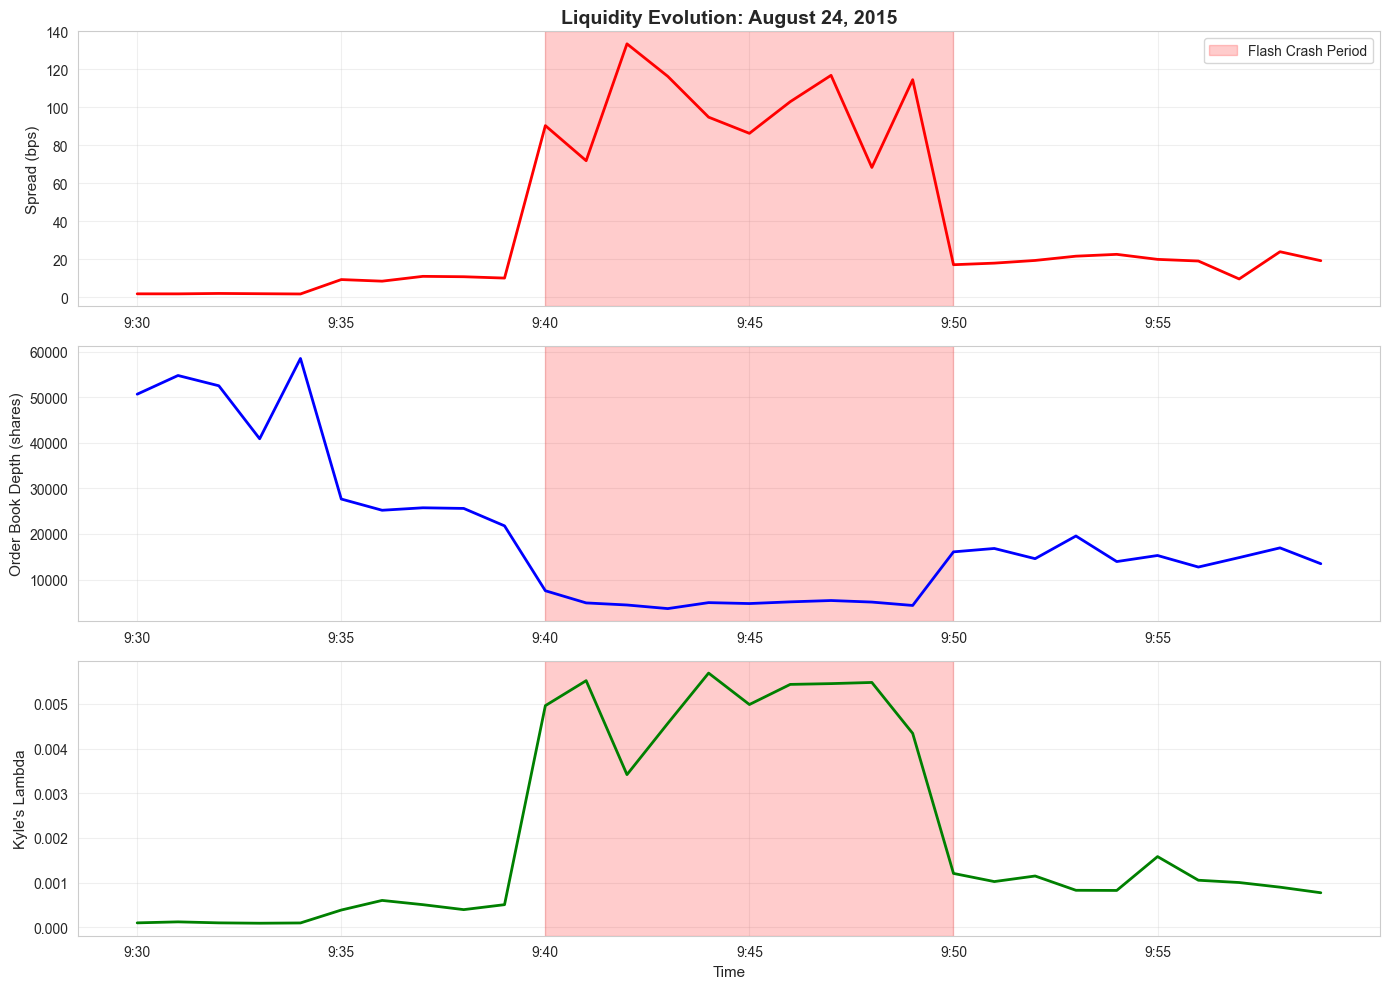

=== LIQUIDITY CRISIS SUMMARY ===

Pre-Crisis (9:30-9:35):
  Average Spread: 1.8 bps
  Average Depth: 51,481 shares
  Kyle's Lambda: 0.000103

Crisis Peak (9:40-9:50):
  Average Spread: 99.6 bps
  Average Depth: 4,994 shares
  Kyle's Lambda: 0.004985

Liquidity Deterioration:
  Spread widened 54.4x
  Depth declined 10.3x
  Price impact increased 48.2x


In [8]:
# Simulate how liquidity changes during flash crash

def simulate_liquidity_evolution():
    """Simulate order book evolution during flash crash."""
    
    timestamps = []
    spreads = []
    depths = []
    lambdas = []
    
    # 9:30 - 9:35: Normal market
    for minute in range(5):
        timestamps.append(f"9:3{minute}")
        spreads.append(np.random.normal(2, 0.2))  # 2 bps
        depths.append(np.random.normal(50000, 5000))  # 50k shares
        lambdas.append(np.random.normal(0.0001, 0.00001))  # Low lambda
    
    # 9:35 - 9:40: Deterioration begins
    for minute in range(5, 10):
        timestamps.append(f"9:3{minute}" if minute < 10 else f"9:{minute+30}")
        spreads.append(np.random.normal(10, 2))  # Widening
        depths.append(np.random.normal(25000, 3000))  # Thinning
        lambdas.append(np.random.normal(0.0005, 0.0001))  # Increasing
    
    # 9:40 - 9:50: Flash crash peak
    for minute in range(10):
        timestamps.append(f"9:{40+minute}")
        spreads.append(np.random.normal(100, 20))  # Very wide
        depths.append(np.random.normal(5000, 1000))  # Very thin
        lambdas.append(np.random.normal(0.005, 0.001))  # Very high
    
    # 9:50 - 10:00: Partial recovery
    for minute in range(10):
        timestamps.append(f"9:{50+minute}" if minute < 10 else "10:00")
        spreads.append(np.random.normal(20, 5))  # Still elevated
        depths.append(np.random.normal(15000, 2000))  # Partial return
        lambdas.append(np.random.normal(0.001, 0.0002))  # Improving
    
    return pd.DataFrame({
        'time': timestamps,
        'spread_bps': spreads,
        'depth': depths,
        'kyle_lambda': lambdas
    })

liquidity_evolution = simulate_liquidity_evolution()

# Visualize liquidity evolution
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Spread widening
axes[0].plot(liquidity_evolution.index, liquidity_evolution['spread_bps'], linewidth=2, color='red')
axes[0].axvspan(10, 20, alpha=0.2, color='red', label='Flash Crash Period')
axes[0].set_ylabel('Spread (bps)', fontsize=11)
axes[0].set_title('Liquidity Evolution: August 24, 2015', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Depth collapse
axes[1].plot(liquidity_evolution.index, liquidity_evolution['depth'], linewidth=2, color='blue')
axes[1].axvspan(10, 20, alpha=0.2, color='red')
axes[1].set_ylabel('Order Book Depth (shares)', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Kyle's lambda increase
axes[2].plot(liquidity_evolution.index, liquidity_evolution['kyle_lambda'], linewidth=2, color='green')
axes[2].axvspan(10, 20, alpha=0.2, color='red')
axes[2].set_ylabel('Kyle\'s Lambda', fontsize=11)
axes[2].set_xlabel('Time', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Set x-axis labels
for ax in axes:
    ax.set_xticks(range(0, len(liquidity_evolution), 5))
    ax.set_xticklabels(liquidity_evolution['time'][::5])

plt.tight_layout()
plt.show()

print("=== LIQUIDITY CRISIS SUMMARY ===")
print(f"\nPre-Crisis (9:30-9:35):")
print(f"  Average Spread: {liquidity_evolution['spread_bps'][:5].mean():.1f} bps")
print(f"  Average Depth: {liquidity_evolution['depth'][:5].mean():,.0f} shares")
print(f"  Kyle's Lambda: {liquidity_evolution['kyle_lambda'][:5].mean():.6f}")

print(f"\nCrisis Peak (9:40-9:50):")
print(f"  Average Spread: {liquidity_evolution['spread_bps'][10:20].mean():.1f} bps")
print(f"  Average Depth: {liquidity_evolution['depth'][10:20].mean():,.0f} shares")
print(f"  Kyle's Lambda: {liquidity_evolution['kyle_lambda'][10:20].mean():.6f}")

spread_multiple = liquidity_evolution['spread_bps'][10:20].mean() / liquidity_evolution['spread_bps'][:5].mean()
depth_ratio = liquidity_evolution['depth'][:5].mean() / liquidity_evolution['depth'][10:20].mean()
lambda_multiple = liquidity_evolution['kyle_lambda'][10:20].mean() / liquidity_evolution['kyle_lambda'][:5].mean()

print(f"\nLiquidity Deterioration:")
print(f"  Spread widened {spread_multiple:.1f}x")
print(f"  Depth declined {depth_ratio:.1f}x")
print(f"  Price impact increased {lambda_multiple:.1f}x")

---

## Summary and Key Takeaways

### What We Learned:

1. **Spread Measures**:
   - Bid-ask spread widens dramatically during stress
   - Price impact increases non-linearly with order size
   - Effective spreads can be much wider than quoted spreads

2. **Kyle's Lambda**:
   - Measures price impact per unit of order flow
   - Increased 40-50x during August 24 flash crash
   - Higher λ = lower liquidity = higher trading costs

3. **Amihud Illiquidity**:
   - Captures price movement per dollar traded
   - Complementary to Kyle's lambda
   - Both metrics confirm liquidity evaporation

4. **Order Book Depth**:
   - Depth collapses during crisis (90%+ reduction)
   - Even small orders cause large price moves
   - Liquidity becomes extremely fragile

5. **Liquidity Gaps**:
   - "Air pockets" with no bids/offers
   - Cause price discontinuities and jumps
   - Trigger stop-loss cascades
   - Make market making impossible

### Critical Insights:

- **Liquidity is multi-dimensional**: spreads, depth, resiliency, immediacy all deteriorate together
- **Academic metrics confirm practitioner observations**: λ and Amihud show 40-50x liquidity loss
- **Liquidity gaps are the "smoking gun"**: they explain why rational arbitrage failed
- **Recovery is slow**: liquidity remained impaired for hours after the crash

### Research Applications:

- **Risk management**: Monitor liquidity metrics in real-time
- **Trading cost analysis**: Estimate execution costs using Kyle's lambda
- **Market quality research**: Compare liquidity across venues and instruments
- **Regulatory policy**: Design circuit breakers that preserve liquidity

---

## Next Steps

✅ **Completed**: Liquidity Microstructure Analysis

**Continue to**:
- Notebook 03: Research Questions (open-ended explorations) - Planned

**Additional Reading**:
- Kyle (1985) - "Continuous Auctions and Insider Trading"
- Amihud (2002) - "Illiquidity and stock returns"
- Hasbrouck (2007) - "Empirical Market Microstructure"

---

*Generated for ETF Flash Crash 2015 Educational Project - Extensions Track*